In [1]:
'''
brew install libomp (for OSX)
pip install torchtext -U
'''
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

c:\Users\user\anaconda3\envs\harco\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch 1.12.1
torchvision 0.13.1


In [2]:
IMG_SIZE = 480

COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 255), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (192, 128, 128), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor
])

# Download Model

In [3]:
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

c:\Users\user\anaconda3\envs\harco\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\harco\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load Image

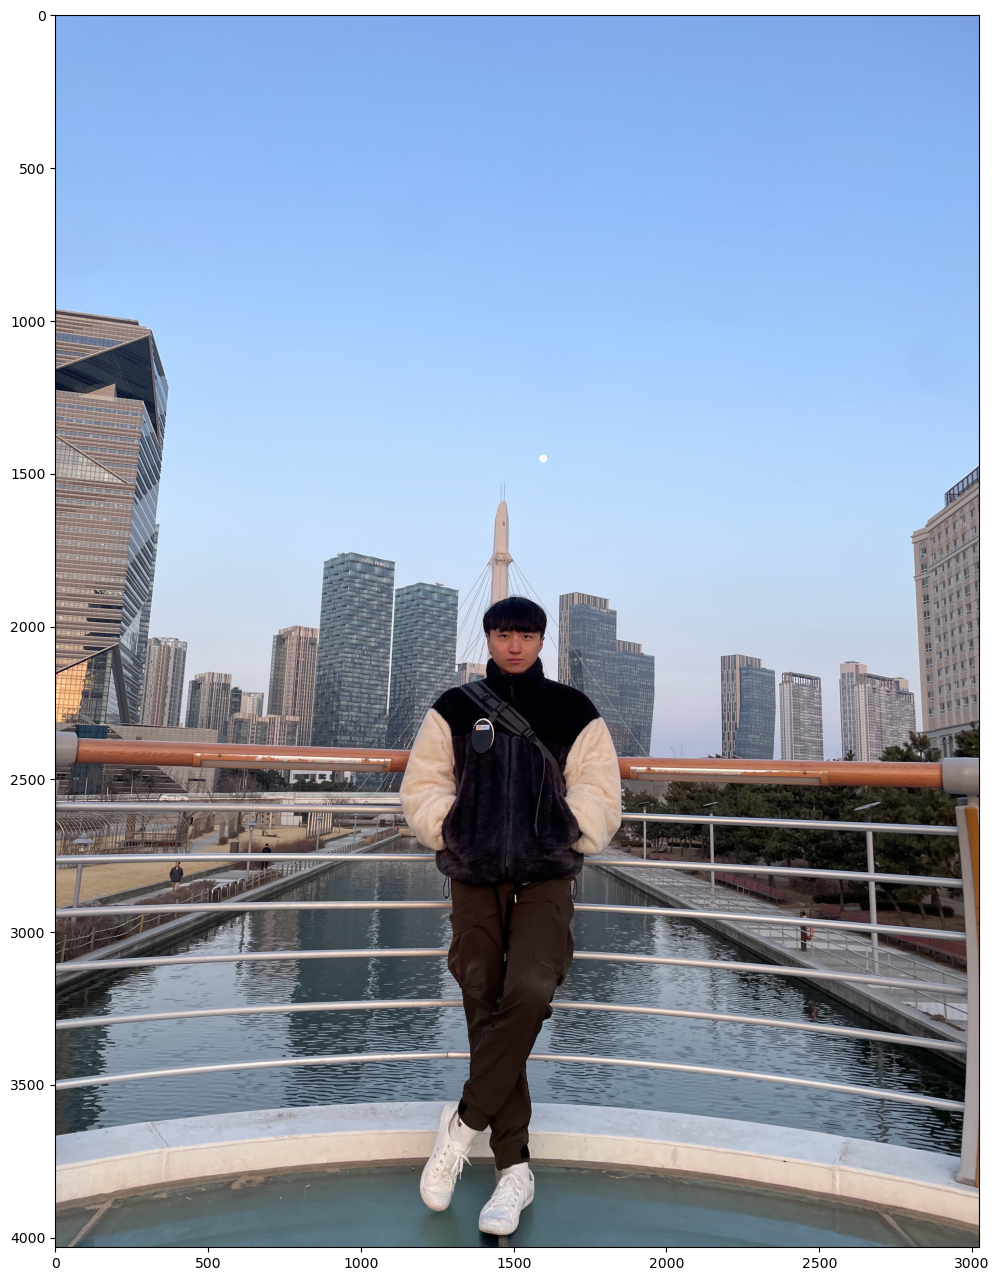

In [4]:
img = Image.open('./images/test2.jpg')

plt.figure(figsize=(16, 16))
plt.imshow(img)

# Image to Tensor

- T.Resize(256) : Resizes the image to size width 256
- T.CenterCrop(224) : Center Crops the image to have a resulting size of 224 x 224
- T.ToTensor() : Converts the image to type torch.Tensor and have values between [0, 1]
- T.Normalize(mean, std) : Normalizes the image with the given mean and standard deviation.

In [5]:
trf = T.Compose([
    T.Resize(IMG_SIZE),
#     T.CenterCrop(IMG_SIZE), # make square image
    T.ToTensor(), 
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_img = trf(img).unsqueeze(0)

# Inference

- [1, 21, 256, 256]
- 1: batch_size
- 21: classes
- 256, 256: image size

In [6]:
out = deeplab(input_img)['out']

print(out.shape)

torch.Size([1, 21, 640, 480])


# Extract Class Map

In [7]:
out = torch.argmax(out.squeeze(), dim=0)
out = out.detach().cpu().numpy()

print(out.shape)
print(np.unique(out))

(640, 480)
[ 0 15]


# Class Map to Segmentation Map

In [8]:
def seg_map(img, n_classes=21):
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for c in range(n_classes):
        idx = img == c

        rgb[idx] = COLORS[c]

    return rgb

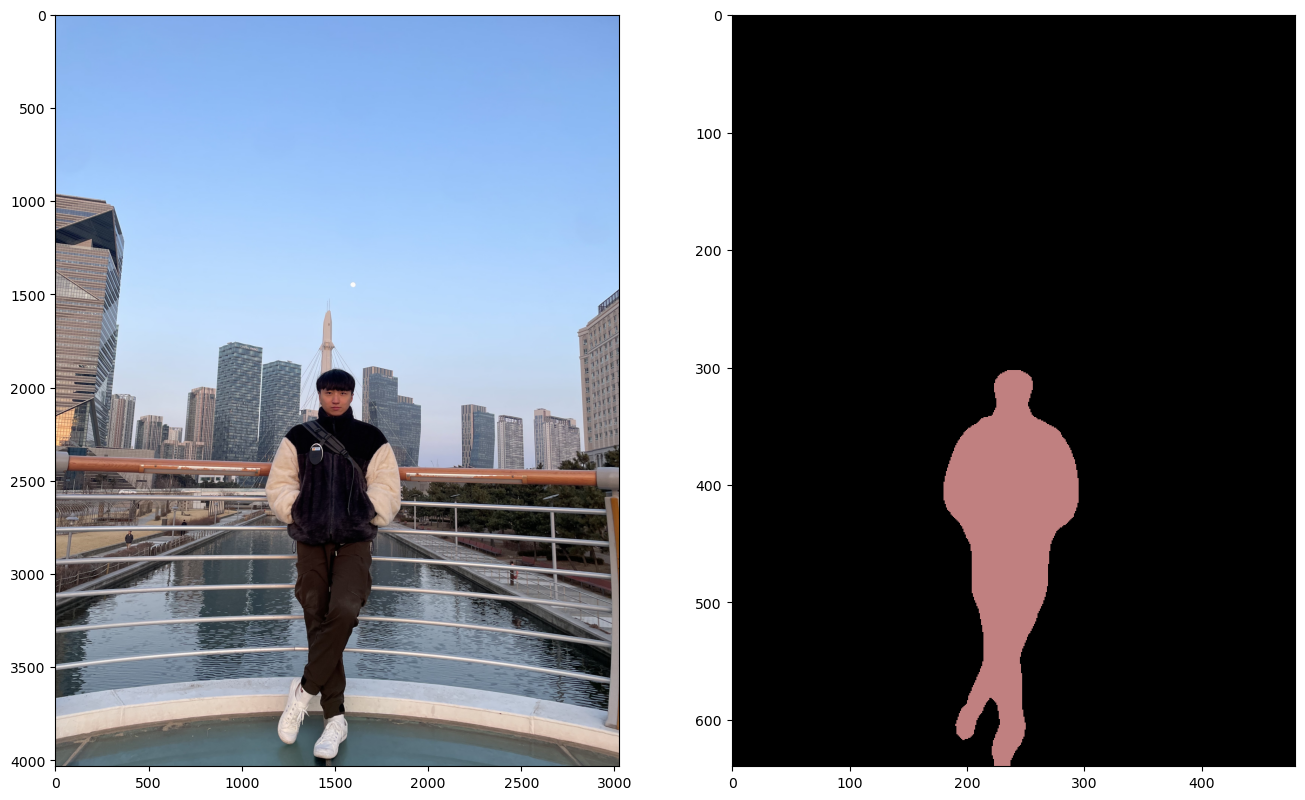

In [9]:
out_seg = seg_map(out)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax[0].imshow(img)
ax[1].imshow(out_seg)

In [10]:
original_img = np.array(img)

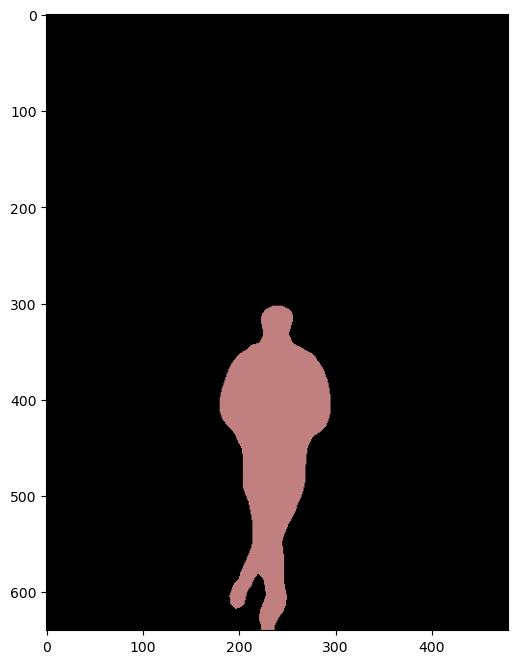

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
ax.imshow(out_seg)

In [12]:
np.array(img)

array([[[135, 175, 236],
        [135, 175, 236],
        [135, 175, 236],
        ...,
        [122, 160, 225],
        [122, 160, 225],
        [122, 160, 225]],

       [[135, 175, 236],
        [135, 175, 236],
        [135, 175, 236],
        ...,
        [122, 160, 225],
        [122, 160, 225],
        [122, 160, 225]],

       [[135, 175, 236],
        [135, 175, 236],
        [135, 175, 236],
        ...,
        [122, 160, 225],
        [122, 160, 225],
        [122, 160, 225]],

       ...,

       [[ 96, 105, 104],
        [ 96, 105, 104],
        [ 96, 105, 104],
        ...,
        [ 88,  87,  83],
        [ 90,  89,  85],
        [ 89,  88,  84]],

       [[ 94, 103, 102],
        [ 97, 106, 105],
        [101, 110, 109],
        ...,
        [ 93,  92,  88],
        [ 96,  95,  91],
        [ 81,  80,  76]],

       [[100, 109, 108],
        [102, 111, 110],
        [103, 112, 111],
        ...,
        [ 90,  89,  85],
        [ 89,  88,  84],
        [ 86,  85,  81]]

In [13]:
from PIL import Image
img  = Image.fromarray(np.array(img))

In [14]:
original = np.array(img.resize([out_seg.shape[1],out_seg.shape[0]]))

In [15]:
original.shape

(640, 480, 3)

In [16]:
out_seg.shape

(640, 480, 3)

In [17]:
overlap = 0.5*original + 0.8*out_seg

In [18]:
overlap.shape

(640, 480, 3)

In [19]:
img  = Image.fromarray(overlap.astype(np.uint8))

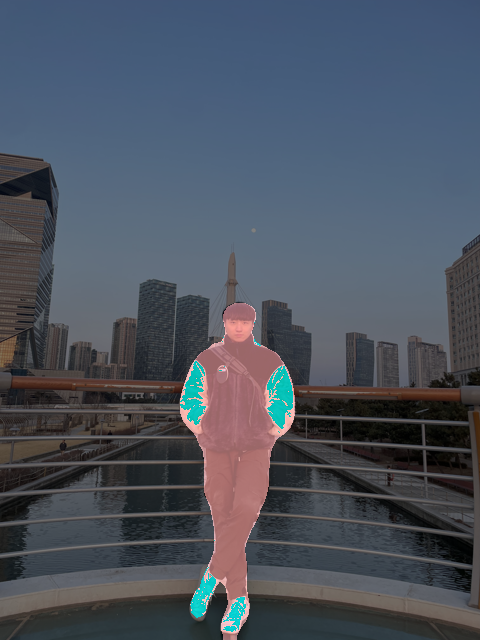

In [20]:
img